# CS 598 DLH Final Project

**Name:** Fabio Vera

**Team:** 133

**Project:** 11

**Github link:** https://github.com/fverac/cs589dlh

**Video link:** https://www.youtube.com/watch?v=ymaahdX9844

**Reproducing:** "Predicting 30-days mortality for MIMIC-III patients with sepsis-3: a machine learning approach using XGboost."

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.base import clone
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_recall_curve, precision_score, \
                            recall_score, f1_score, confusion_matrix, classification_report, \
                            PrecisionRecallDisplay, roc_auc_score, RocCurveDisplay
# may have to install xgboost via `pip install xgboost`
from xgboost import XGBClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

import time

pd.set_option('display.max_columns', None)

# Introduction
<!-- This is an introduction to your report, you should edit this text/mardown section to compose. In this text/markdown, you should introduce:

*   Background of the problem
  * what type of problem: disease/readmission/mortality prediction,  feature engineeing, data processing, etc
  * what is the importance/meaning of solving the problem
  * what is the difficulty of the problem
  * the state of the art methods and effectiveness.
*   Paper explanation
  * what did the paper propose
  * what is the innovations of the method
  * how well the proposed method work (in its own metrics)
  * what is the contribution to the reasearch regime (referring the Background above, how important the paper is to the problem). -->


Sepsis accounts for over 5.3 million deaths a year and has an approximate mortality of 30%. With such a high mortality rate, it is desirable to construct an accurate and reliable prognostic (or survival classification) model to inform the allocation of scarce clinical resources. Past attempts at such a prognostic model have either employed traditional predictive methods such as logistic regression, or the use of clinical scoring systems such as Simplified Acute Physiology Score-II. These approaches however, can be limiting in their assumptions or scope of features used for prediction. Machine learning methods such as XGboost may be able to achieve higher performance, with the ability to handle many features and identify nonlinear relationships in the data.

The paper I am reproducing proposes using XGBoost for this classification task, and demonstrates improvement in performance over typical models such as logistic regression, achieving an AUC of 0.857 using XGboost vs 0.819 using logistic regression.

I will attempt to reproduce their classification experiments, and compare the performance of XGboost on the dataset against traditional methods such as logistic regression.

# Scope of Reproducibility:

<!-- List hypotheses from the paper you will test and the corresponding experiments you will run.


1.   Hypothesis 1: xxxxxxx
2.   Hypothesis 2: xxxxxxx

You can insert images in this notebook text, [see this link](https://stackoverflow.com/questions/50670920/how-to-insert-an-inline-image-in-google-colaboratory-from-google-drive) and example below:

![sample_image.png](https://drive.google.com/uc?export=view&id=1g2efvsRJDxTxKz-OY3loMhihrEUdBxbc) -->


Hypotheses:
1. I will see if XGboost can achieve higher performance than logistic regression in sepsis mortality prediction.

# Methodology

## Envionment

Full environment.yml included in GitHub repo. 

For convenience, below is a summary of important packages/dependencies:

* Python 3.9.12
* scikit-learn 1.0.2
* pandas 1.4.2
* numpy 1.21.5
* xgboost 2.0.3
* matplotlib 3.5.1

##  Data
<!-- Data includes raw data (MIMIC III tables), descriptive statistics (our homework questions), and data processing (feature engineering).
  * Source of the data: where the data is collected from; if data is synthetic or self-generated, explain how. If possible, please provide a link to the raw datasets.
  * Statistics: include basic descriptive statistics of the dataset like size, cross validation split, label distribution, etc.
  * Data process: how do you munipulate the data, e.g., change the class labels, split the dataset to train/valid/test, refining the dataset.
  * Illustration: printing results, plotting figures for illustration.
  * You can upload your raw dataset to Google Drive and mount this Colab to the same directory. If your raw dataset is too large, you can upload the processed dataset and have a code to load the processed dataset. -->

Data is all from MIMIC III v1.4, which "is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012. The database includes information such as demographics, vital sign measurements made at the bedside (~1 data point per hour), laboratory test results, procedures, medications, caregiver notes, imaging reports, and mortality (including post-hospital discharge)."

Data can be obtained from this link after completing the required training.
https://physionet.org/content/mimiciii/1.4/

Precomputed features like first-day vital signs and many more were obtained from Google BigQuery, which in addition to storing 
More information as well as underlying code for creating these precomputed/derived tables can be found here: 
https://github.com/MIT-LCP/mimic-code/tree/main/mimic-iii/concepts

Additionally, here are some resources for accessing MIMIC through BigQuery:
https://mimic.mit.edu/docs/gettingstarted/cloud/bigquery/

#### Sepsis filters

Obtain diagnosis codes for sepsis, to be used for filtering downstream

In [3]:
# icd9 codes I care about
sepsis_codes = (
    pd.read_csv(f'mimic-iii-clinical-database-1.4/D_ICD_DIAGNOSES.csv')
    .loc[lambda df: df['SHORT_TITLE'].str.lower().isin(['sepsis', 'severe sepsis', 'septic shock'])] #sepsis”, “severe sepsis” and “septic shock”
    ['ICD9_CODE']
    .values
)
sepsis_codes

array(['99591', '99592', '78552'], dtype=object)

In [ ]:
diagnoses = pd.read_csv('mimic-iii-clinical-database-1.4/DIAGNOSES_ICD.csv')
diagnoses

In [ ]:
sepsis_diagnoses = (
    diagnoses
    .loc[
        lambda df: df['ICD9_CODE'].isin(sepsis_codes)
    ]
)
sepsis_diagnoses

#### Loading and cleaning master table

In [6]:
# helper function to print shape and message via .pipe, while returning df to continue data processing
def print_shape(df, msg = ''):
    print(msg, df.shape)
    return df

#### Data pipeline

Filters data and merges features while printing shape at every step.

In [67]:
Xy = (
    pd.read_csv('mimic_concepts/icustay_detail.csv') # table of all icu stays along with demographic information
    .pipe(print_shape, 'Initial shape: ')
    .loc[lambda df: df['hadm_id'].isin(sepsis_diagnoses['HADM_ID'])] # sepsis filter
    .pipe(print_shape, 'After filtering to sepsis: ')

    .loc[lambda df: df['first_hosp_stay']] # only keep first hospital stays
    .loc[lambda df: df['first_icu_stay']] # only keep first icu stay info
    .pipe(print_shape, 'After filtering to first hospital+icu stay: ')

    .loc[lambda df: df['admission_age'].ge(18)] # age filter
    .loc[lambda df: df['admission_age'].le(89)] # age filter
    .pipe(print_shape, 'After filtering ages: ')

    # create y marker
    .assign(
        death_within_30 = lambda df:
        df['hospital_expire_flag']
        # if length of stay > 30, mark as not dead within 30 days
        .mask(
            df['los_hospital'].gt(30),
            0
        )
    )
    
    # inner merge all features. Don't lose too many rows
    .merge(
        pd.read_csv('mimic_concepts/labs_first_day.csv'),
        how='inner',
        on = ['subject_id', 'hadm_id', 'icustay_id'],
    )
    .merge(
        pd.read_csv('mimic_concepts/heightweight.csv'),
        how='inner',
        on = ['icustay_id'],
    )
    .merge(
        pd.read_csv('mimic_concepts/vitals_first_day.csv'),
        how='inner', # this drops like 20 rows
        on = ['subject_id', 'hadm_id', 'icustay_id'],
    ) # deal with conflicting glucose vals
    .merge(
        pd.read_csv('mimic_concepts/gcs_first_day.csv'),
        how='inner',
        on = ['subject_id', 'hadm_id', 'icustay_id'],
    )
    .merge(
        pd.read_csv('mimic_concepts/elixhauser_ahrq_v37.csv')
        # only keep cols with at least 1% of data. maybe just drop this..
        .loc[
            :,
            lambda df:
            df.sum().div(df.shape[0]).gt(0.01)
        ],
        how='inner',
        on = ['subject_id', 'hadm_id'],
    )
    .merge(
        pd.read_csv('mimic_concepts/ventilation_first_day.csv'),
        how='inner',
        on = ['subject_id', 'hadm_id', 'icustay_id'],
    )
    .merge(
        pd.read_csv('mimic_concepts/rrt_first_day.csv'),
        how='inner',
        on = ['subject_id', 'hadm_id', 'icustay_id'],
    )
    .merge(
        pd.read_csv('mimic_concepts/urine_output_first_day.csv'),
        how='inner', #this drops a few hundred
        on = ['subject_id', 'hadm_id', 'icustay_id'],
    )
    .merge(
        pd.read_csv('mimic_concepts/sapsii.csv')[['subject_id', 'hadm_id', 'icustay_id', 'sapsii']],
        how='inner', #this drops a few hundred
        on = ['subject_id', 'hadm_id', 'icustay_id'],
    )
    .merge(
        pd.read_csv('mimic_concepts/sofa.csv')[['subject_id', 'hadm_id', 'icustay_id', 'SOFA']],
        how='inner', #this drops a few hundred
        on = ['subject_id', 'hadm_id', 'icustay_id'],
    )
    .merge(
        pd.read_csv('mimic_concepts/qsofa.csv')[['subject_id', 'hadm_id', 'icustay_id', 'qSOFA']],
        how='inner', #this drops a few hundred
        on = ['subject_id', 'hadm_id', 'icustay_id'],
    )
    .pipe(print_shape, 'After inner-merging on features: ')


    
    # drop columns not intended for modeling
    .drop(
        columns=[
            'icustay_id',
            'dod',
            'admittime',
            'dischtime',
            'los_hospital',
            'ethnicity',
            'hospital_expire_flag',
            'hospstay_seq',
            'first_hosp_stay',
            'intime',
            'outtime',
            'los_icu',
            'icustay_seq',
            'first_icu_stay',
            'subject_id',
            'hadm_id'
        ]
    )
    
    # drop rows where >20% features are missing
    .loc[
        lambda df:
        df
        .isna()
        .sum(axis=1)
        .div(df.shape[1]).lt(0.2)
    ]
    .pipe(print_shape, 'After dropping rows where >20% features are missing: ')



    # xgboost can natively handle categorical, and onehot, but maybe in interest of time just do it in pandas
    .assign(gender = lambda df: df['gender'].replace({'F':0, 'M': 1}))
    .pipe(
        lambda df:
        pd.concat([
            df.drop(columns='ethnicity_grouped'),
            df['ethnicity_grouped'].pipe(pd.get_dummies, prefix='ethnicity')
        ], axis=1)
    )
    # .fillna(-1)
    
    .reset_index(drop=True)
    .pipe(print_shape, 'Final shape: ')

)
# Xy

Initial shape:  (61051, 19)
After filtering to sepsis:  (6126, 19)
After filtering to first hospital+icu stay:  (3534, 19)
After filtering ages:  (3262, 19)
After inner-merging on features:  (3169, 102)
After dropping rows where >20% features are missing:  (3155, 86)
Final shape:  (3155, 92)


#### Data exploration

In [69]:
# target value counts
Xy['death_within_30'].value_counts()

0    2295
1     860
Name: death_within_30, dtype: int64

In [70]:
# observe most commonly missing features
Xy.isna().sum().sort_values(ascending=False).head(20)

bands_min        1842
bands_max        1842
height_first     1565
height_max       1563
height_min       1563
albumin_min      1121
albumin_max      1121
bilirubin_max     674
bilirubin_min     674
lactate_max       341
lactate_min       341
ptt_min           191
ptt_max           191
pt_max            181
pt_min            181
inr_max           181
inr_min           181
gcsmotor           44
weight_max         36
weight_min         36
dtype: int64

##   Model
<!-- The model includes the model definitation which usually is a class, model training, and other necessary parts.
  * Model architecture: layer number/size/type, activation function, etc
  * Training objectives: loss function, optimizer, weight of each loss term, etc
  * Others: whether the model is pretrained, Monte Carlo simulation for uncertainty analysis, etc
  * The code of model should have classes of the model, functions of model training, model validation, etc.
  * If your model training is done outside of this notebook, please upload the trained model here and develop a function to load and test it. -->
  

### Model description 

XGBoost is a tree based model that at a high level has many benefits, including the ability to learn nonlinear patterns in the data, and handle categorical and missing values natively. From a technical standpoint, XGBoost is an ensemble model that combines multiple weak learners to obtain better performance. It combines the learners through a framework called gradient boosting, which sequentially builds new models to correct the errors of the previous one. 

The main comparison model is logistic regression, which is a classical linear classification model. One of the expected limitations of logistic regression is in its linearity, which in theory XGBoost can outperform since it makes no such linearity assumptions. 

### Hyperparameter tuning, preprocessing, and ablations:

I try 16 different combinations of models and preprocessing steps. 

In particular, for the models I tried logistic regression out of the box as well as logistic regression cv, which optimizes the regularization strength by cross validating over the training data. For XGBoost I tried an out of the box version, a "tailored" version I found on the internet, and a gridsearched version of XGBoost which attempted to optimize several key hyperparameters (max_depth, learning_rate, n_estimators, colsample_bytree) by cross validating over the training set.

For preprocessing, tried all combinations of scaling the data and imputing missing values with the mean, including no preprocessing. I explored these because I know scaling can be important for regularized linear models like logistic regression, and also that XGBoost can handle missing values natively, so I wanted to see whether or not these preprocessing steps mattered at all for performance.

### Computational requirements

The training experiments were run on a 2021 M1 Macbook Pro with 16 gb of memory. 

Additionally, average fold train time per model type is described below in the Runtimes section, adding up to a total of about 80 minutes for training all in all. 

Overall, we tried 16 combinations of model and preprocessing steps. 

In [71]:
y_col = 'death_within_30'
X = Xy.drop(columns=[y_col])
y = Xy[y_col]

In [167]:
models_dict = {
    'logisticregression_out_of_the_box': LogisticRegression(random_state=1),
    'logisticregressioncv': LogisticRegressionCV(Cs= 5, max_iter=3000, random_state=1, cv=3, penalty='elasticnet', l1_ratios=[0, 1, 0.5], solver='saga'),
    'xgboost_out_of_the_box': XGBClassifier(random_state=1),
    'xgboost_gridsearch': GridSearchCV(
        estimator=XGBClassifier(random_state=1),
            param_grid={
                'max_depth': [3, 6, 10],
                'learning_rate': [0.01, 0.1, 0.3],
                'n_estimators': [500],
                'colsample_bytree': [0.35, 0.7]
            },
            scoring='roc_auc',
            cv=3
        ),
    'xgboost_tailored': XGBClassifier(
                learning_rate =0.1,
                n_estimators=1000,
                max_depth=4,
                min_child_weight=6,
                gamma=0,
                subsample=0.8,
                colsample_bytree=0.8,
                objective= 'binary:logistic',
                nthread=4,
                scale_pos_weight=1,
                seed=27)

}

In [168]:
preprocessing_steps_dict = {
    'scale': [StandardScaler()],
    'scale_impute': [StandardScaler(), SimpleImputer()],
    'impute': [SimpleImputer()],
    'none': []
}

In [169]:
%%time 

pred_df = pd.DataFrame()
times_df = pd.DataFrame()

kf = KFold(n_splits=5, shuffle=True, random_state=1)

for model_name in models_dict:
    print(model_name)
    for preprocessing_steps_name in preprocessing_steps_dict:
        print('\t', preprocessing_steps_name)
        
        # skip if not imputing missing values because logistic regression doesn't handle missing out of box
        if 'logistic' in model_name and 'impute' not in preprocessing_steps_name:
            continue
        iteration_name = ':'.join([model_name, preprocessing_steps_name])
        
        for i, (train_index, test_index) in enumerate(kf.split(X)):
            start_time = time.time()

            
            X_train = X.iloc[train_index]
            y_train = y.iloc[train_index]
            X_test = X.iloc[test_index]
            y_test = y.iloc[test_index]

            model = clone(models_dict[model_name]) # clone the model to make sure it is unfitted
            preprocessing_steps = preprocessing_steps_dict[preprocessing_steps_name]
            pipeline = make_pipeline(*preprocessing_steps + [model])

            pipeline.fit(X_train, y_train)
            preds = pipeline.predict(X_test)
            pred_probas = pipeline.predict_proba(X_test)[:, 1]
            
            iteration_info_dict = {
                'iteration_name': iteration_name,
                'model_name': model_name,
                'preprocessing_steps': preprocessing_steps_name,
            }

            pred_df_fold = pd.DataFrame(
                iteration_info_dict | {
                'y_actual': y_test,
                'y_pred': preds,
                'y_pred_proba': pred_probas,
                'fold': i,
                'test_inds': test_index
            })
            pred_df = pd.concat([pred_df, pred_df_fold])
            
            end_time = time.time()
            runtime = end_time - start_time
            time_row = (
                pd.Series(iteration_info_dict | {
                    'fold': i,
                    'fold_runtime': runtime
                })
                .to_frame()
                .T
            )
            times_df = pd.concat([times_df, time_row])
    
    

logisticregression_out_of_the_box
	 scale
	 scale_impute
	 impute
	 none
logisticregressioncv
	 scale
	 scale_impute
	 impute
	 none
xgboost_out_of_the_box
	 scale
	 scale_impute
	 impute
	 none
xgboost_gridsearch
	 scale
	 scale_impute
	 impute
	 none
xgboost_tailored
	 scale
	 scale_impute
	 impute
	 none
CPU times: user 1h 51min 2s, sys: 1h 3min 3s, total: 2h 54min 6s
Wall time: 1h 21min 3s


# Evaluation and Results
<!-- In this section, you should finish training your model training or loading your trained model. That is a great experiment! You should share the results with others with necessary metrics and figures.

Please test and report results for all experiments that you run with:

*   specific numbers (accuracy, AUC, RMSE, etc)
*   figures (loss shrinkage, outputs from GAN, annotation or label of sample pictures, etc) -->


We record several metrics for our classification task, accuracy, precision, recall, f1 score, and ROC AUC. Each evaluates a different aspect of performance. We will focus on ROC AUC since that is the primary evaluation metric that the original paper used. ROC AUC calculates the Area Under the ROC Curve, where the ROC Curve plots the tradeoff between True Positive Rate and False Positive Rate. The higher the AUC, the better the model. 

For completeness, we will plot ROC curves for both the best logistic regression model and the best XGboost model, as a visual guide to their performance differences.

## Main Results Table: 

Performance of each model+preprocessing step combination.

Contrary to the original paper, logistic regression is the best performing model, with ~0.822 AUC, whereas the best XGBoost model attained ~0.817 AUC. It's worthwhile to note that performance discrepancies are not really significant between all of the models. There is less than 0.01 AUC difference between the best logistic regression and the best XGBoost model, while there is about ~0.03 difference between the best and the worst model.

Another thing these experiments seem to suggest is that optimizing XGBoost hyperparameters is more important than optimizing logistic regression hyperparameters, and optimizing preprocessing is more important for logistic regression than it is for XGBoost. Through the results table we see that "xgboost_gridsearch" outperformed all other iterations of xgboost across all preprocessing steps, while the "scale_impute" logistic regression models always perform better than their "impute" counterparts.

In [170]:
iteration_summary_df = pd.DataFrame()


for iteration_name in pred_df['iteration_name'].unique():
    pred_df_iteration = pred_df.loc[lambda df: df['iteration_name'].eq(iteration_name)]
    model_name, preprocessing_steps_name = iteration_name.split(':')
    
    iteration_summary_row = (
        pd.Series({
            'iteration_name': iteration_name,
            'model_name': model_name,
            'preprocessing_steps': preprocessing_steps_name,
            'accuracy': metrics.accuracy_score(pred_df_iteration['y_actual'], pred_df_iteration['y_pred']),
            'precision': metrics.precision_score(pred_df_iteration['y_actual'], pred_df_iteration['y_pred']),
            'recall': metrics.recall_score(pred_df_iteration['y_actual'], pred_df_iteration['y_pred']),
            'f1': metrics.f1_score(pred_df_iteration['y_actual'], pred_df_iteration['y_pred']),
            'ROC_AUC': metrics.roc_auc_score(pred_df_iteration['y_actual'], pred_df_iteration['y_pred_proba']),
        })
        .to_frame()
        .T
    )
    
    iteration_summary_df = pd.concat([iteration_summary_df, iteration_summary_row])

    
iteration_summary_df = iteration_summary_df.sort_values('ROC_AUC', ascending=False)
iteration_summary_df

,iteration_name,model_name,preprocessing_steps,accuracy,precision,recall,f1,ROC_AUC
0,logisticregression_out_of_the_box:scale_impute,logisticregression_out_of_the_box,scale_impute,0.794612,0.689286,0.448837,0.543662,0.82156
0,logisticregressioncv:scale_impute,logisticregressioncv,scale_impute,0.794929,0.729032,0.394186,0.511698,0.82029
0,xgboost_gridsearch:scale,xgboost_gridsearch,scale,0.798098,0.743982,0.395349,0.516325,0.817355
0,xgboost_gridsearch:none,xgboost_gridsearch,none,0.797147,0.740175,0.394186,0.514416,0.816862
0,xgboost_gridsearch:scale_impute,xgboost_gridsearch,scale_impute,0.795563,0.737307,0.388372,0.508759,0.816173
0,xgboost_gridsearch:impute,xgboost_gridsearch,impute,0.794295,0.737079,0.381395,0.502682,0.813867
0,xgboost_tailored:none,xgboost_tailored,none,0.783835,0.638629,0.476744,0.545939,0.812403
0,xgboost_out_of_the_box:scale,xgboost_out_of_the_box,scale,0.785737,0.649837,0.463953,0.541384,0.808331
0,xgboost_out_of_the_box:impute,xgboost_out_of_the_box,impute,0.787639,0.66323,0.448837,0.535368,0.808152
0,xgboost_out_of_the_box:scale_impute,xgboost_out_of_the_box,scale_impute,0.787005,0.653595,0.465116,0.543478,0.807813


## Model deep dives

In [171]:
# Best logistic regression model 
best_logistic_regression_iteration_row = iteration_summary_df.loc[lambda df: df['model_name'].str.contains('logistic')].iloc[[0]]
best_logistic_regression_iteration = best_logistic_regression_iteration_row['iteration_name'].values[0]
best_logistic_regression_iteration_pred_df = pred_df.loc[lambda df: df['iteration_name'].eq(best_logistic_regression_iteration)]

best_logistic_regression_iteration_row


,iteration_name,model_name,preprocessing_steps,accuracy,precision,recall,f1,ROC_AUC
0,logisticregression_out_of_the_box:scale_impute,logisticregression_out_of_the_box,scale_impute,0.794612,0.689286,0.448837,0.543662,0.82156


In [172]:
# Best xgboost model 
best_xgb_iteration_row = iteration_summary_df.loc[lambda df: df['model_name'].str.contains('xgb')].iloc[[0]]
best_xgb_iteration = best_xgb_iteration_row['iteration_name'].values[0]
best_xgb_iteration_pred_df = pred_df.loc[lambda df: df['iteration_name'].eq(best_xgb_iteration)]
best_xgb_iteration_row

,iteration_name,model_name,preprocessing_steps,accuracy,precision,recall,f1,ROC_AUC
0,xgboost_gridsearch:scale,xgboost_gridsearch,scale,0.798098,0.743982,0.395349,0.516325,0.817355


#### ROC metrics

Here we overlay the ROC curves of the best logistic regression model and the best XGBoost model. Visually they look very similar.

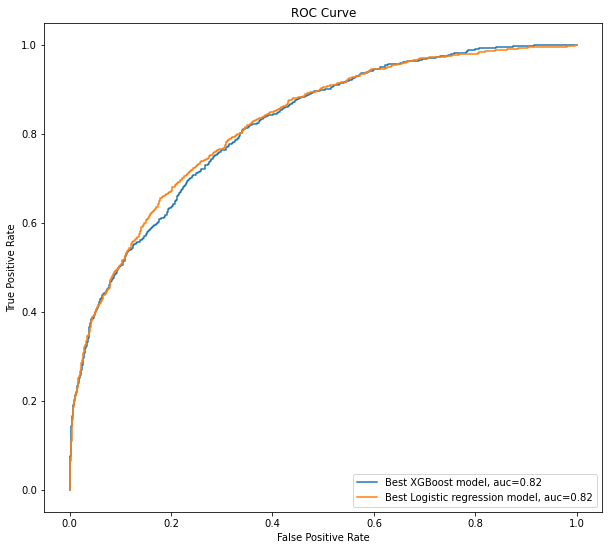

In [173]:
fig, ax = plt.subplots(figsize=(10, 9))

fpr, tpr, thresh = metrics.roc_curve(best_xgb_iteration_pred_df['y_actual'], best_xgb_iteration_pred_df['y_pred_proba'])
auc = metrics.roc_auc_score(best_xgb_iteration_pred_df['y_actual'], best_xgb_iteration_pred_df['y_pred_proba'])
plt.plot(fpr,tpr,label=f'Best XGBoost model, auc={auc:.2f}')

fpr, tpr, thresh = metrics.roc_curve(best_logistic_regression_iteration_pred_df['y_actual'], best_logistic_regression_iteration_pred_df['y_pred_proba'])
auc = metrics.roc_auc_score(best_logistic_regression_iteration_pred_df['y_actual'], best_logistic_regression_iteration_pred_df['y_pred_proba'])
plt.plot(fpr,tpr,label=f'Best Logistic regression model, auc={auc:.2f}')

ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.legend(loc=4)

## Runtimes

See below average fold runtime for each of the model+preprocessing combinations tried. The gridsearched XGBoost model clearly took the most time, since it had to search over several parameters using the training data.

In [178]:
(
    times_df
    .groupby([
        'iteration_name',
        'model_name',
        'preprocessing_steps',
    ])
    ['fold_runtime']
    .agg(
        total_iteration_runtime = 'sum',
        mean_fold_runtime = 'mean'
    )
    .reset_index()
)

,iteration_name,model_name,preprocessing_steps,total_iteration_runtime,mean_fold_runtime
0,logisticregression_out_of_the_box:impute,logisticregression_out_of_the_box,impute,0.672642,0.134528
1,logisticregression_out_of_the_box:scale_impute,logisticregression_out_of_the_box,scale_impute,0.573674,0.114735
2,logisticregressioncv:impute,logisticregressioncv,impute,190.451209,38.090242
3,logisticregressioncv:scale_impute,logisticregressioncv,scale_impute,179.757807,35.951561
4,xgboost_gridsearch:impute,xgboost_gridsearch,impute,1100.207111,220.041422
5,xgboost_gridsearch:none,xgboost_gridsearch,none,1186.618116,237.323623
6,xgboost_gridsearch:scale,xgboost_gridsearch,scale,1057.332465,211.466493
7,xgboost_gridsearch:scale_impute,xgboost_gridsearch,scale_impute,1086.061112,217.212222
8,xgboost_out_of_the_box:impute,xgboost_out_of_the_box,impute,4.622737,0.924547
9,xgboost_out_of_the_box:none,xgboost_out_of_the_box,none,10.527162,2.105432


Total experiment runtimes

In [175]:
total_runtime = times_df['fold_runtime'].sum()
print('Total runtime:', total_runtime/60, 'min')

Total runtime: 81.05540145635605 min


# Discussion

<!-- In this section,you should discuss your work and make future plan. The discussion should address the following questions:
  * Make assessment that the paper is reproducible or not.
  * Explain why it is not reproducible if your results are kind negative.
  * Describe “What was easy” and “What was difficult” during the reproduction.
  * Make suggestions to the author or other reproducers on how to improve the reproducibility.
  * What will you do in next phase. -->



Through all my experiments, I was not able to achieve the performance that the original paper did. The original paper achieved ~0.85 AUC. In my draft I obtained .806 AUC with XGBoost configuration I found on the internet. After optimizing my XGBoost by playing with combinations of missing value imputation as well as gridsearching over parameters, I did obtain a better performance, reaching 0.817 AUC, but still not as good as quoted in the original paper. Nevertheless, performance is still much better than random, which indicates that these models could still be useful in a clinical setting (if deployed appropriately).

In terms of what was difficult, I underestimated how much work it was going to be to process the data to be ready for modeling. There is a lot of feature engineering required on the raw data to get it into a state that is ready for modeling. In particular, the raw CHARTEVENTS table is quite large (~30 gb uncompressed) and understandably has most of the rich features, but its size makes it quite difficult to deal with on a compute station like a laptop. Thankfully, I was able to find and leverage several precomputed derived tables on BigQuery to make the feature engineering process smoother. 

Once the data was processed and ready, the modeling was the easy part. At least with respect to trying out of the box versions of XGBoost and logistic regression and evaluating their performance. It got trickier again once I had to try and optimize the performance of these models.

As a suggestion for the authors, the single most important thing the authors could do to improve reproducibility would be to release their code. This could clear things up across the whole process, from the way they train the model to the way they ingest and process the data.

# References

1. Hou, N., Li, M., He, L. et al. Predicting 30-days mortality for MIMIC-III patients with sepsis-3: a machine learning approach using XGboost. J Transl Med 18, 462 (2020). https://doi.org/10.1186/s12967-020-02620-5
2. Johnson, A., Pollard, T., & Mark, R. (2016). MIMIC-III Clinical Database (version 1.4). PhysioNet. https://doi.org/10.13026/C2XW26.
3. Johnson, A. E. W., Pollard, T. J., Shen, L., Lehman, L. H., Feng, M., Ghassemi, M., Moody, B., Szolovits, P., Celi, L. A., & Mark, R. G. (2016). MIMIC-III, a freely accessible critical care database. Scientific Data, 3, 160035.
4. Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.
5. Jain, Aarshay. “XGBoost Parameters Tuning | Complete Guide With Python Codes.” Analytics Vidhya, 07 Jan 2024
